In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import sqlite3

In [4]:
target_csv = "./data/LosAngeles.csv"
csv_losAngeles = pd.read_csv(target_csv,low_memory=False)
target_csv = "./data/AirQualitySystem.csv"
csv_AirQuality = pd.read_csv(target_csv,low_memory=False)

In [102]:
data_url = "https://api.openaq.org/v1/measurements?city=Los Angeles"
data_content = requests.get(data_url)

In [104]:
data_results = data_content.json()
series = {}
series['Los Angeles'] = {}
for data in data_results['results']:
    if data['parameter'] in series['Los Angeles'].keys():
        if data['value'] > 0 :
            series['Los Angeles'][data['parameter']]['value'].append(data['value'])
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            series['Los Angeles'][data['parameter']]['time'].append(timepoint.tm_yday+timepoint.tm_hour/24)
        else :
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            timepoint = timepoint.tm_yday+timepoint.tm_hour/24
            if timepoint in series['Los Angeles'][data['parameter']]['error'].keys():
                series['Los Angeles'][data['parameter']]['error'][timepoint] += 1
            else :
                series['Los Angeles'][data['parameter']]['error'][timepoint] = 1
            
    else:
        series['Los Angeles'][data['parameter']] = {}
        series['Los Angeles'][data['parameter']]['value'] = []
        series['Los Angeles'][data['parameter']]['time'] = []
        series['Los Angeles'][data['parameter']]['error'] = {}
        if data['value'] > 0 :
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            series['Los Angeles'][data['parameter']]['value'].append(data['value'])
            series['Los Angeles'][data['parameter']]['time'].append(timepoint.tm_yday+timepoint.tm_hour/24)
        else :
            timepoint = time.strptime(data['date']['utc'],"%Y-%m-%dT%H:%M:%S.%fZ")
            timepoint = timepoint.tm_yday+timepoint.tm_hour/24
            if timepoint in series['Los Angeles'][data['parameter']]['error'].keys():
                series['Los Angeles'][data['parameter']]['error'][timepoint] += 1
            else :
                series['Los Angeles'][data['parameter']]['error'][timepoint] = 1
            

(array([290.4, 290.6, 290.8, 291. , 291.2, 291.4, 291.6, 291.8, 292. ,
        292.2]), <a list of 10 Text xticklabel objects>)

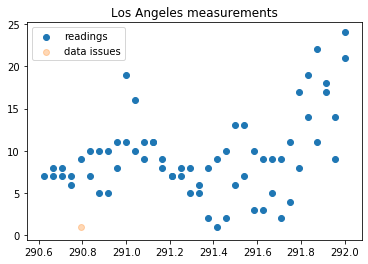

In [109]:
plt.scatter(series['Los Angeles']['pm25']['time'],series['Los Angeles']['pm25']['value'])
plt.scatter(series['Los Angeles']['pm25']['error'].keys(),series['Los Angeles']['pm25']['error'].values(),alpha=.3)
plt.title('Los Angeles measurements')
plt.legend(["readings","data issues"])
plt.xticks()

In [5]:
csv_losAngeles

,date,parameter,location,value,unit,city,attribution,averagingperiod,coordinates,country,sourcename,sourcetype,mobile
0,"{utc=2017-08-11T00:00:00.000Z, local=2017-08-1...",co,Azusa,0.340,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=34.136475, longitude=-117.923965}",US,AirNow,government,False
1,"{utc=2017-08-11T00:00:00.000Z, local=2017-08-1...",no2,Azusa,0.015,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=34.136475, longitude=-117.923965}",US,AirNow,government,False
2,"{utc=2017-08-11T00:00:00.000Z, local=2017-08-1...",o3,Azusa,0.061,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=34.136475, longitude=-117.923965}",US,AirNow,government,False
3,"{utc=2017-08-11T00:00:00.000Z, local=2017-08-1...",co,Glendora - Laurel,0.240,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=34.1439, longitude=-117.8508}",US,AirNow,government,False
4,"{utc=2017-08-11T00:00:00.000Z, local=2017-08-1...",no2,Glendora - Laurel,0.012,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=34.1439, longitude=-117.8508}",US,AirNow,government,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
986029,"{utc=2019-04-03T20:00:00.000Z, local=2019-04-0...",co,Mission Viejo,0.110,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=33.62999, longitude=-117.67587}",US,AirNow,government,False
986030,"{utc=2019-04-03T20:00:00.000Z, local=2019-04-0...",o3,Mission Viejo,0.042,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=33.62999, longitude=-117.67587}",US,AirNow,government,False
986031,"{utc=2019-04-03T20:00:00.000Z, local=2019-04-0...",co,La Habra,0.100,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=33.92506, longitude=-117.95258}",US,AirNow,government,False
986032,"{utc=2019-04-03T20:00:00.000Z, local=2019-04-0...",no2,La Habra,0.003,ppm,Los Angeles-Long Beach-Santa Ana,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=33.92506, longitude=-117.95258}",US,AirNow,government,False


In [6]:
connection = sqlite3.connect('weather-store.db')
cursor = connection.cursor()
#create table co table
creation_table = """CREATE TABLE co_parameter
                    (source text,reading real,unit text,latitude real,longitude real,confidence real,date text)"""
cursor.execute(creation_table)
connection.commit()
connection.close()

In [23]:
#setup database connection
connection = sqlite3.connect('weather-store.db')
cursor = connection.cursor()
#start writing to db
insert_statement = """INSERT INTO co_parameter Values(?,?,?,?,?,?,?)"""
#create value list
count = 0
inserts = []
for index,row in csv_losAngeles.iterrows():
    count += 1
    coords = row['coordinates'].replace("{","").replace("}","")
    coords = coords.split(",")
    location = {'latitude' : float(coords[0].split("=")[1]),'longitude' : float(coords[1].split("=")[1])}
    date = row['date'].replace("{","").replace("}","")
    date = date.split(",")[0].split("=")[1]
    inserts.append([row['sourcename'],row['value'],row['unit'],location['latitude'],location['longitude'],0,date])
    if count > 1000:
        cursor.executemany(insert_statement,inserts)
        count = 0
        inserts = []
        

In [24]:
connection.commit()
connection.close()